In [1]:
!unzip /content/audi_sam.zip

Archive:  /content/audi_sam.zip
replace audi_sam/sample-000001.mp3? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install openai-whisper pydub librosa matplotlib scikit-learn

!pip install numpy==1.23.5
!pip install librosa==0.10.0.post2
!pip install SpeechRecognition
!pip install nltk
!pip install praat-parselmouth




N


In [3]:

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
import os
import numpy as np
import librosa
import whisper
import matplotlib.pyplot as plt
import speech_recognition as sr
import parselmouth
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

from pydub import AudioSegment, silence
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
from google.colab import files

uploaded = files.upload()
audio_files = list(uploaded.keys())


Saving sample-000029 (1).mp3 to sample-000029 (1).mp3
Saving sample-000119.mp3 to sample-000119.mp3
Saving sample-000076.mp3 to sample-000076.mp3
Saving sample-000058.mp3 to sample-000058.mp3
Saving sample-000039.mp3 to sample-000039.mp3
Saving sample-000029.mp3 to sample-000029.mp3
Saving sample-000028.mp3 to sample-000028.mp3
Saving sample-000003.mp3 to sample-000003.mp3
Saving sample-000014.mp3 to sample-000014.mp3
Saving sample-000001.mp3 to sample-000001.mp3


In [6]:
from pydub import AudioSegment
import os
import subprocess
import sys

subprocess.call(['apt-get', 'install', '-y', 'ffmpeg'])
subprocess.call([sys.executable, '-m', 'pip', 'install', 'pydub'])

converted_files = []
for file in uploaded:
    if not file.lower().endswith('.wav'):
        audio = AudioSegment.from_file(file)
        output = os.path.splitext(file)[0] + ".wav"
        audio.export(output, format="wav")
        converted_files.append(output)
    else:
        converted_files.append(file)

audio_files = converted_files


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [7]:
model = whisper.load_model("base")

def transcribe_audio(file_path):
    result = model.transcribe(file_path)
    return result["text"]

transcripts = {file: transcribe_audio(file) for file in audio_files}


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 95.5MiB/s]
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  

In [12]:
HESITATION_MARKERS = [
    'uh', 'um', 'erm', 'ah', 'eh', 'hmm', 'mm', 'uhh', 'umm', 'like', 'you know', 'well', 'so'
]

COMMON_SUBSTITUTIONS = [
    'thing', 'stuff', 'that', 'you know', 'whatever', 'something', 'somehow', 'somewhere',
    'kinda', 'sorta', 'maybe', 'possibly', 'probably', 'thingy', 'whatchamacallit', 'doohickey',
    'thingamajig', 'thingamabob'
]
INCOMPLETE_ENDINGS = [
    'and', 'but', 'so', 'because', 'if', 'when', 'while', 'though',
    'although', 'unless', 'until', 'as', 'since', 'whereas', 'even though'
]


def extract_speech_features(audio_path):
    y, sr_rate = librosa.load(audio_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr_rate)

    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    pitch_values = pitch_values[pitch_values > 0]
    pitch_std = np.std(pitch_values) if pitch_values.size > 0 else 0

    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)
    except:
        text = ""

    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())

    pauses = librosa.effects.split(y, top_db=30)
    pause_durations = [
        (pauses[i][0] - pauses[i - 1][1]) / sr_rate
        for i in range(1, len(pauses))
    ]
    avg_pauses = len(pause_durations) / len(sentences) if sentences else 0

    hesitation_count = sum(words.count(h) for h in HESITATION_MARKERS)
    substitution_count = sum(words.count(w) for w in COMMON_SUBSTITUTIONS)
    speech_rate = (len(words) / duration) * 60 if duration > 0 else 0
    incomplete_sentences = sum(
        s.strip().lower().endswith(t) for s in sentences for t in INCOMPLETE_ENDINGS
    )

    return {
        "text": text,
        "pauses_per_sentence": avg_pauses,
        "hesitation_count": hesitation_count,
        "substitution_count": substitution_count,
        "speech_rate": speech_rate,
        "pitch_std": pitch_std,
        "incomplete_sentences": incomplete_sentences
    }

In [13]:
from pydub import AudioSegment
import os

converted_files = []

for audio_path in audio_files[:]:
    ext = os.path.splitext(audio_path)[1].lower()
    if ext not in ['.wav', '.aiff', '.aifc', '.flac']:
        audio = AudioSegment.from_file(audio_path, format="mp3")
        wav_path = audio_path.rsplit('.', 1)[0] + ".wav"
        audio.export(wav_path, format="wav")

        audio_files.remove(audio_path)
        converted_files.append(wav_path)

audio_files.extend(converted_files)


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

feature_data = [extract_speech_features(path) for path in audio_files]

if len(feature_data) > 1:
    feature_matrix = np.array([list(data.values())[1:] for data in feature_data])
    normalized_data = StandardScaler().fit_transform(feature_matrix)

    model = KMeans(n_clusters=2, random_state=42)
    cluster_assignments = model.fit_predict(normalized_data)

    for i, path in enumerate(audio_files):
        print(f"{path}: Assigned to Cluster {cluster_assignments[i]}")
else:
    print("Clustering requires at least two audio inputs.")


sample-000029 (1).wav: Assigned to Cluster 0
sample-000119.wav: Assigned to Cluster 0
sample-000076.wav: Assigned to Cluster 0
sample-000058.wav: Assigned to Cluster 0
sample-000039.wav: Assigned to Cluster 1
sample-000029.wav: Assigned to Cluster 1
sample-000028.wav: Assigned to Cluster 1
sample-000003.wav: Assigned to Cluster 0
sample-000014.wav: Assigned to Cluster 0
sample-000001.wav: Assigned to Cluster 1


sample-000029 (1).wav: belongs to Cluster 0
sample-000119.wav: belongs to Cluster 0
sample-000076.wav: belongs to Cluster 0
sample-000058.wav: belongs to Cluster 0
sample-000039.wav: belongs to Cluster 1
sample-000029.wav: belongs to Cluster 1
sample-000028.wav: belongs to Cluster 1
sample-000003.wav: belongs to Cluster 0
sample-000014.wav: belongs to Cluster 0
sample-000001.wav: belongs to Cluster 1


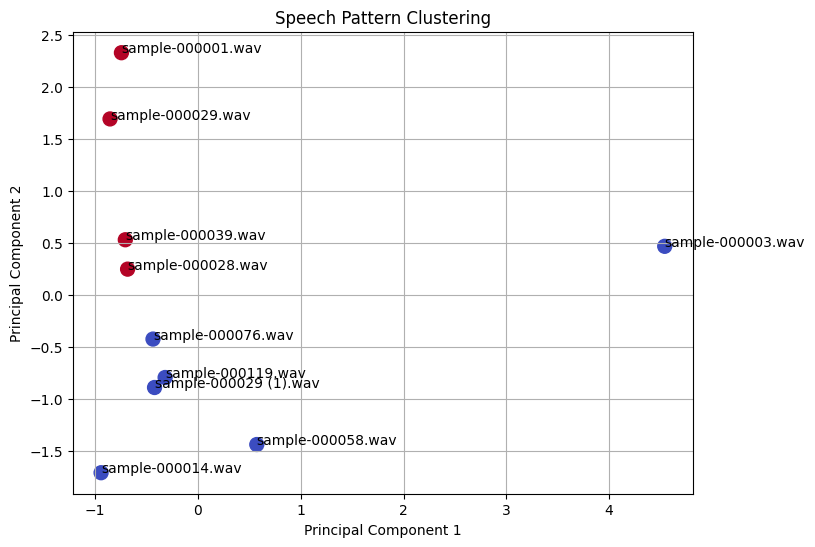

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

speech_data = [extract_speech_features(audio) for audio in audio_files]

if len(speech_data) > 1:
    feature_vectors = np.array([list(data.values())[1:] for data in speech_data])

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_vectors)

    kmeans_model = KMeans(n_clusters=2, random_state=42)
    cluster_labels = kmeans_model.fit_predict(normalized_features)

    for index, name in enumerate(audio_files):
        print(f"{name}: belongs to Cluster {cluster_labels[index]}")

    pca_model = PCA(n_components=2)
    reduced_features = pca_model.fit_transform(normalized_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap='coolwarm', s=100)

    for i, name in enumerate(audio_files):
        plt.annotate(name, (reduced_features[i, 0], reduced_features[i, 1]))

    plt.title("Speech Pattern Clustering")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()
else:
    print("Insufficient audio files: at least two are required for clustering and PCA.")
